In [116]:
import math
import sys
import numpy as np
import re
import string
import random
from random import randint
import cv2
import os

%env XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/lib/cuda/
%env LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/

from collections import Counter
from matplotlib import pyplot as plt
from PIL import Image, ImageFont, ImageDraw
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plti



env: XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/lib/cuda/
env: LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/


In [117]:
# CONSTANTS
IM_PATH = "/home/fizzer/labelled_plates"
DST_PATH = "/home/fizzer/labelled_dsts"
NUM_LABELS = 26
CONFIDENCE_THRESHOLD = 0.01
VALIDATION_SPLIT = 0.1
LEARNING_RATE = 5e-5
HSV_LOWER = np.array([115,80,90])
HSV_UPPER = np.array([130,255,205])
DST_LOWER = np.array([0,0,0])
DST_UPPER = np.array([0,0,90])

In [118]:
# PLATES
CP_PATH = "/home/fizzer/cnn_trainer/letter_model/cps/"
SAVE_PATH = "/home/fizzer/cnn_trainer/letter_model/save/"

In [119]:
# DSTS
# CP_PATH = "/home/fizzer/cnn_trainer/dst_model/cps/"
# SAVE_PATH = "/home/fizzer/cnn_trainer/dst_model/save/"

In [120]:
# Set up one hot reference 
one_hot_ref = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
def one_hot_map(c):
    arr = np.zeros(len(one_hot_ref))
    arr[one_hot_ref.find(c)] = 1
    return arr

In [121]:
i = cv2.imread(f"{IM_PATH}/PLT_000013_IP61.png")
hsv = cv2.cvtColor(i, cv2.COLOR_BGR2HSV)
blur = cv2.GaussianBlur(hsv, (5,5), cv2.BORDER_DEFAULT)
# Mask -> Get contours -> Take 4 Largest contours
i_mask = cv2.inRange(blur, HSV_LOWER, HSV_UPPER)
contours, _ = cv2.findContours(i_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts_sorted = np.flip(sorted(contours, key=lambda x: cv2.contourArea(x))[-4:])
# Sort contours left to right
rects = []
for cnt in cnts_sorted:
    x,y,w,h = cv2.boundingRect(cnt)
    rects.append([x,y,w,h])
rects = np.array(rects)
rects = sorted(rects, key=lambda x: x[0])
# Show a slice
x,y,w,h = rects[0]
# cv2.imshow("img", i_mask[y:y+h,x:x+w])
# cv2.waitKey(1)

/home/fizzer/miniconda3/envs/tf/lib/python3.9/site-packages/numpy/lib/function_base.py:334: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  m = asarray(m)


In [122]:
KERNEL = np.ones((3,3), np.uint8)
def get_char(img, char, rect):
    x,y,w,h = rect
    im = cv2.resize(img[y:y+h,x:x+w], (75,100))
    im = cv2.erode(cv2.dilate(im, KERNEL, iterations=1), KERNEL, iterations=1)
    return (one_hot_map(char), im)

In [123]:
# THIS IS FOR READING THE PLATE NUMBERS/LETTERS
def crop_plate(plate_path):
    img = cv2.imread(f"{IM_PATH}/{plate_path}")
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    blur = cv2.GaussianBlur(hsv, (3,3), cv2.BORDER_DEFAULT)
    mask = cv2.inRange(blur, HSV_LOWER, HSV_UPPER)
    # Mask -> Get contours -> Take 4 Largest contours
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts_sorted = np.flip(sorted(contours, key=lambda x: cv2.contourArea(x))[-4:])
    rects = []
    for cnt in cnts_sorted:
        x,y,w,h = cv2.boundingRect(cnt)
        rects.append([x,y,w,h])
    rects = np.array(rects)
    rects = sorted(rects, key=lambda x: x[0])
    # Perform image processing
    return get_char(mask, plate_path[-8], rects[0]), get_char(mask, plate_path[-7], rects[1]), get_char(mask, plate_path[-6], rects[2]), get_char(mask, plate_path[-5], rects[3])

In [124]:
# THIS IS FOR READING THE "CAR NUMBER"
def crop_dst(plate_path):
    img = cv2.imread(f"{DST_PATH}/{plate_path}")
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    blur = cv2.GaussianBlur(hsv, (3,3), cv2.BORDER_DEFAULT)
    mask = cv2.inRange(hsv, DST_LOWER, DST_UPPER)
    # Mask -> Get contours -> Take 4 Largest contours
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts_sorted = np.flip(sorted(contours, key=lambda x: cv2.contourArea(x))[-2:])
    rects = []
    for cnt in cnts_sorted:
        x,y,w,h = cv2.boundingRect(cnt)
        rects.append([x,y,w,h])
    rects = np.array(rects)
    rects = sorted(rects, key=lambda x: x[0])
    return get_char(mask, plate_path[-5], rects[1])

In [125]:
imset = []

# Read plates
dir_contents = np.array(os.listdir(IM_PATH))
for im_path in dir_contents:
 # Plates
   p1,p2,p3,p4 = crop_plate(im_path)
   imset.extend([p1,p2,p3,p4])

# Read dsts
# dir_contents = np.array(os.listdir(DST_PATH))
# for im_path in dir_contents:
#   # DSTs
#    p1 = crop_dst(im_path)
#    imset.extend([p1])


dataset = np.array(imset)
np.random.shuffle(dataset)

/tmp/ipykernel_68842/734422063.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataset = np.array(imset)


In [126]:
x_dataset = np.array([img[1][:] for img in imset[:]])
y_dataset = np.array([img[0] for img in imset[:]])
x_dataset = x_dataset/255.0
x_dataset = x_dataset.reshape(len(x_dataset), len(x_dataset[0]), len(x_dataset[0][0]), -1)
print(x_dataset.shape)

(3104, 100, 75, 1)


In [127]:
# TODO: The following was copy pasted - validate
def reset_weights(model):
    for ix, layer in enumerate(model.layers):
        if (hasattr(model.layers[ix], 'kernel_initializer') and 
            hasattr(model.layers[ix], 'bias_initializer')):
            weight_initializer = model.layers[ix].kernel_initializer
            bias_initializer = model.layers[ix].bias_initializer

            old_weights, old_biases = model.layers[ix].get_weights()

            model.layers[ix].set_weights([
                weight_initializer(shape=old_weights.shape),
                bias_initializer(shape=len(old_biases))])

In [128]:
conv_model = models.Sequential()
conv_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                             input_shape=(100, 75, 1)))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(48, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dropout(0.5))
conv_model.add(layers.Dense(256, activation='relu'))
conv_model.add(layers.Dense(36, activation='softmax'))
cp_callback = callbacks.ModelCheckpoint(filepath=CP_PATH, save_weights_only=True, verbose=1)

In [129]:
conv_model.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.RMSprop(learning_rate=LEARNING_RATE),
                   metrics=['acc'])

In [130]:
history_conv = conv_model.fit(x_dataset, y_dataset, 
                              validation_split=VALIDATION_SPLIT, 
                              epochs=20, 
                              batch_size=16,
                              callbacks=[cp_callback])

Epoch 1/30
170/175 [============================>.] - ETA: 0s - loss: 3.1988 - acc: 0.2301
Epoch 1: saving model to /home/fizzer/cnn_trainer/letter_model/cps/
175/175 [==============================] - 1s 4ms/step - loss: 3.1802 - acc: 0.2352 - val_loss: 2.4249 - val_acc: 0.4469
Epoch 2/30
167/175 [===========================>..] - ETA: 0s - loss: 1.7929 - acc: 0.5943
Epoch 2: saving model to /home/fizzer/cnn_trainer/letter_model/cps/
175/175 [==============================] - 1s 3ms/step - loss: 1.7642 - acc: 0.5997 - val_loss: 1.0999 - val_acc: 0.7267
Epoch 3/30
171/175 [============================>.] - ETA: 0s - loss: 1.0246 - acc: 0.7610
Epoch 3: saving model to /home/fizzer/cnn_trainer/letter_model/cps/
175/175 [==============================] - 1s 3ms/step - loss: 1.0241 - acc: 0.7623 - val_loss: 0.7664 - val_acc: 0.8457
Epoch 4/30
172/175 [============================>.] - ETA: 0s - loss: 0.7891 - acc: 0.8358
Epoch 4: saving model to /home/fizzer/cnn_trainer/letter_model/cps/
1

In [131]:
conv_model.save(SAVE_PATH)

INFO:tensorflow:Assets written to: /home/fizzer/cnn_trainer/letter_model/save/assets


INFO:tensorflow:Assets written to: /home/fizzer/cnn_trainer/letter_model/save/assets


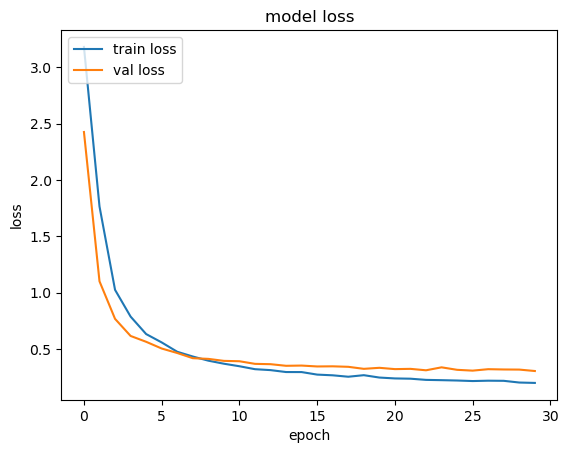

In [132]:
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

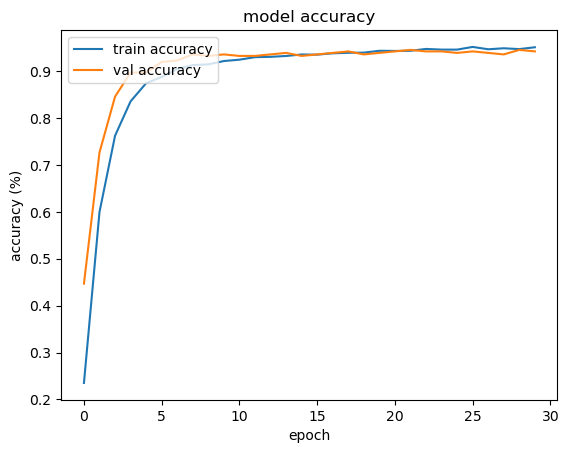

In [133]:
plt.plot(history_conv.history['acc'])
plt.plot(history_conv.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
plt.show()

In [134]:
from sklearn.metrics import confusion_matrix

97/97 [==============================] - 0s 972us/step


<AxesSubplot:>

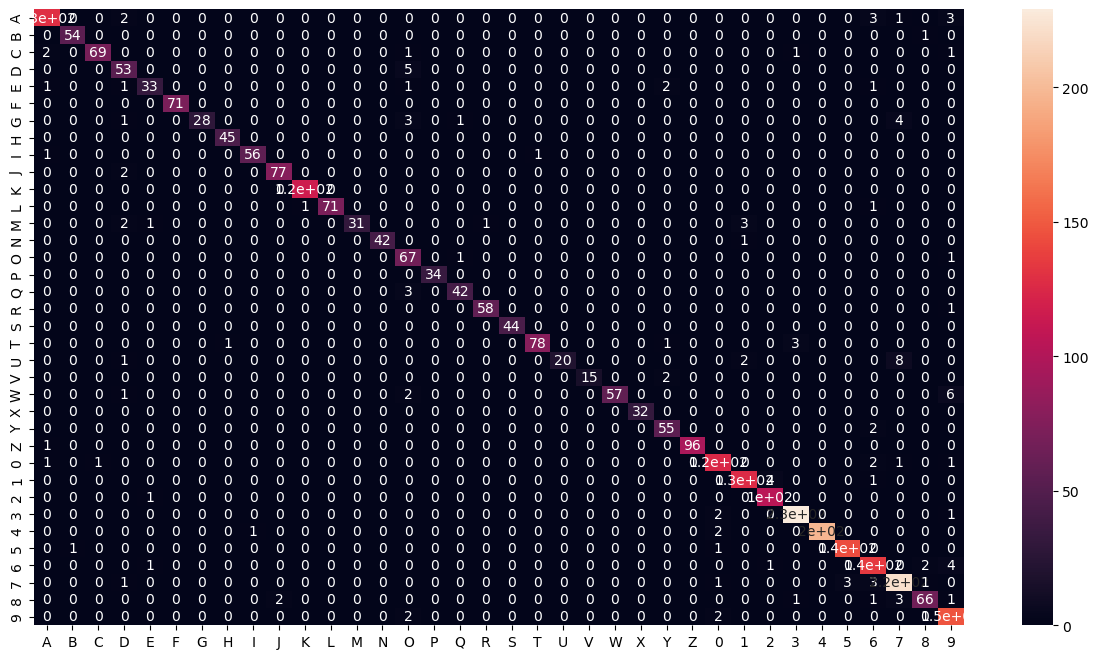

In [135]:
pred_matrix = conv_model.predict(x_dataset)

pred_results = [np.argmax(pred) for pred in pred_matrix]
corr_results = [np.argmax(Y_val) for Y_val in y_dataset]

conf_matrix = confusion_matrix(corr_results, pred_results)

df_cm = pd.DataFrame(conf_matrix, index = [i for i in one_hot_ref],
                  columns = [i for i in one_hot_ref])
plt.figure(figsize = (15,8))
sn.heatmap(df_cm, annot=True)

In [136]:
pred_matrix = conv_model.predict(x_dataset)
pred_results = [np.argmax(pred) for pred in pred_matrix]
corr_results = [np.argmax(Y_val) for Y_val in y_dataset]

97/97 [==============================] - 0s 998us/step


In [137]:
print(conv_model.predict(x_dataset)[0])

97/97 [==============================] - 0s 976us/step
[1.6528988e-05 5.0935270e-08 6.8499824e-09 5.9339919e-07 8.5705636e-08
 4.4790753e-09 2.0921007e-06 1.7881428e-08 2.2727703e-07 2.7485103e-09
 1.2388008e-04 1.7742266e-07 1.3422153e-05 2.8787475e-05 4.0822135e-07
 9.9253858e-09 2.0997741e-06 8.0197642e-06 2.1748650e-05 1.9468496e-05
 1.8420416e-05 6.2833360e-06 4.5685195e-07 9.9800605e-01 1.6520674e-03
 3.4482204e-05 2.9573686e-08 3.4220942e-05 7.6363893e-09 1.4916240e-07
 1.9975571e-06 6.4226833e-07 4.6976717e-07 6.8516524e-06 6.6619023e-08
 1.0010242e-07]


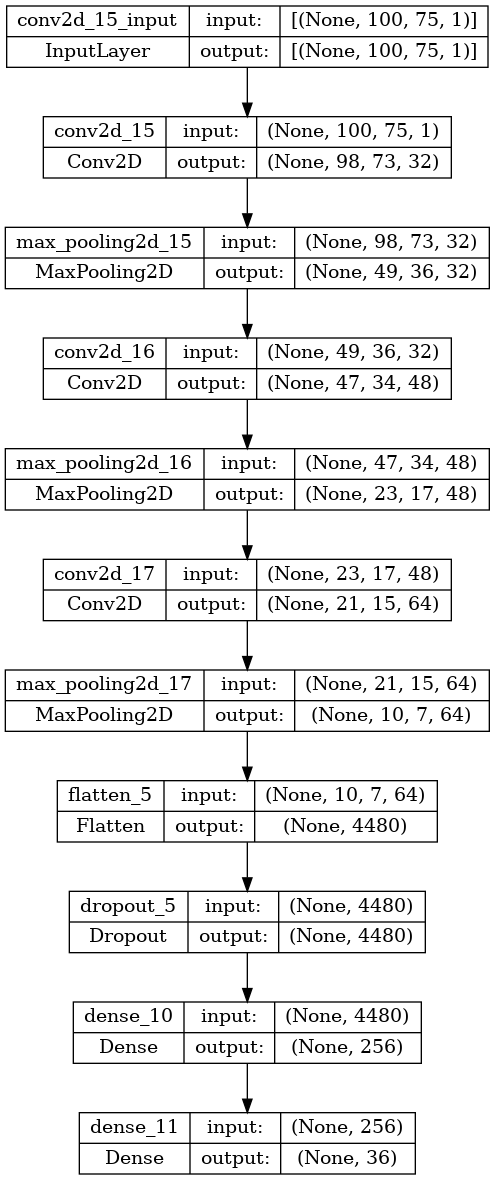

In [138]:
plot_model(conv_model, to_file='letter_model.png', show_shapes=True)